## Kue Dataset - Model2

overfit model2


In [1]:
# conda install -c conda-forge keras

In [2]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# PATH_DATA = '../data/'
# PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_IMAGES = 'drive/MyDrive/Repository/Data/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = 'drive/MyDrive/Repository/Model/'

In [5]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_risoles',
 'kue_klepon',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_lapis',
 'kue_serabi']

## Modeling

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


In [7]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [63]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 200

In [64]:
just_cake_model = Sequential()
just_cake_model.add(Conv2D(180, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Conv2D(180, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.2))
just_cake_model.add(Conv2D(360, (3, 3), activation ='relu'))
just_cake_model.add(Conv2D(360, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.2))
just_cake_model.add(Conv2D(90, (3, 3), activation ='relu'))
just_cake_model.add(Conv2D(90, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Conv2D(45, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))


just_cake_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
just_cake_model.add(Dense(256, activation ='relu'))
just_cake_model.add(Dense(32, activation ='relu'))
just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

In [65]:
just_cake_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 198, 198, 180)     5040      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 99, 99, 180)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 97, 97, 180)       291780    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 180)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 48, 180)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 46, 46, 360)       583560    
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 44, 44, 360)      

In [66]:
## compile model
opt = optimizers.Adam(learning_rate=0.001)
just_cake_model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',metrics.AUC()])

In [67]:
## data generator
BATCH_SIZE = 64
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [68]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=8) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model-colab2.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=100)

Epoch 1/100
23/23 [==============================] - 37s 1s/step - loss: 2.0807 - accuracy: 0.1208 - auc_5: 0.5123 - val_loss: 1.9024 - val_accuracy: 0.2109 - val_auc_5: 0.6367
Epoch 2/100
23/23 [==============================] - 34s 1s/step - loss: 1.9752 - accuracy: 0.1971 - auc_5: 0.6299 - val_loss: 1.9024 - val_accuracy: 0.2812 - val_auc_5: 0.6738
Epoch 3/100
23/23 [==============================] - 34s 1s/step - loss: 1.8834 - accuracy: 0.2422 - auc_5: 0.6956 - val_loss: 1.7758 - val_accuracy: 0.2344 - val_auc_5: 0.7492
Epoch 4/100
23/23 [==============================] - 34s 1s/step - loss: 1.8074 - accuracy: 0.2325 - auc_5: 0.7268 - val_loss: 1.6565 - val_accuracy: 0.2500 - val_auc_5: 0.7802
Epoch 5/100
23/23 [==============================] - 34s 1s/step - loss: 1.7646 - accuracy: 0.2350 - auc_5: 0.7436 - val_loss: 1.6286 - val_accuracy: 0.3047 - val_auc_5: 0.8070
Epoch 6/100
23/23 [==============================] - 33s 1s/step - loss: 1.7528 - accuracy: 0.2845 - auc_5: 0.7564 

## Evaluations

In [69]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

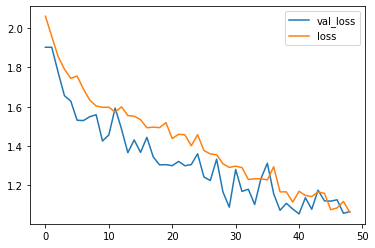

In [70]:
df_epoch_hist[['val_loss','loss']].plot()

In [71]:
# df_epoch_hist.to_csv('../artifact/epoch_hist_2-overfit2.csv')

In [72]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model-colab2.h5',compile=False)
# model_load = load_model(PATH_MODEL + 'just_cake_model-colab2.h5')



In [73]:
true_labels = val_generator.classes
predictions = model_load.predict(val_generator)

# true_labels = train_generator.classes
# predictions = model_load.predict(train_generator)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

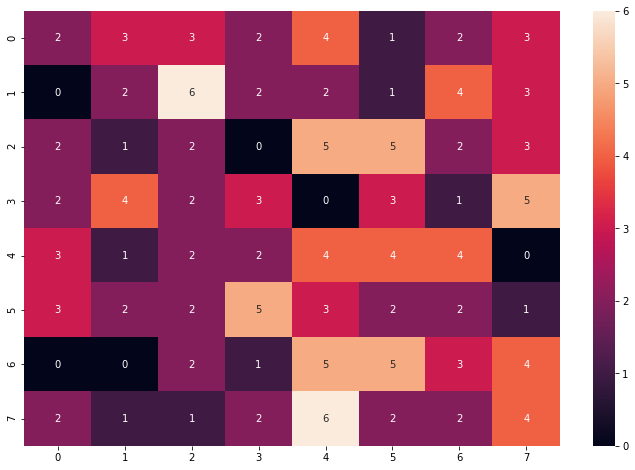

In [74]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [75]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        20
           1       0.14      0.10      0.12        20
           2       0.10      0.10      0.10        20
           3       0.18      0.15      0.16        20
           4       0.14      0.20      0.16        20
           5       0.09      0.10      0.09        20
           6       0.15      0.15      0.15        20
           7       0.17      0.20      0.19        20

    accuracy                           0.14       160
   macro avg       0.14      0.14      0.14       160
weighted avg       0.14      0.14      0.14       160

